In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
from scipy.spatial import distance as dist

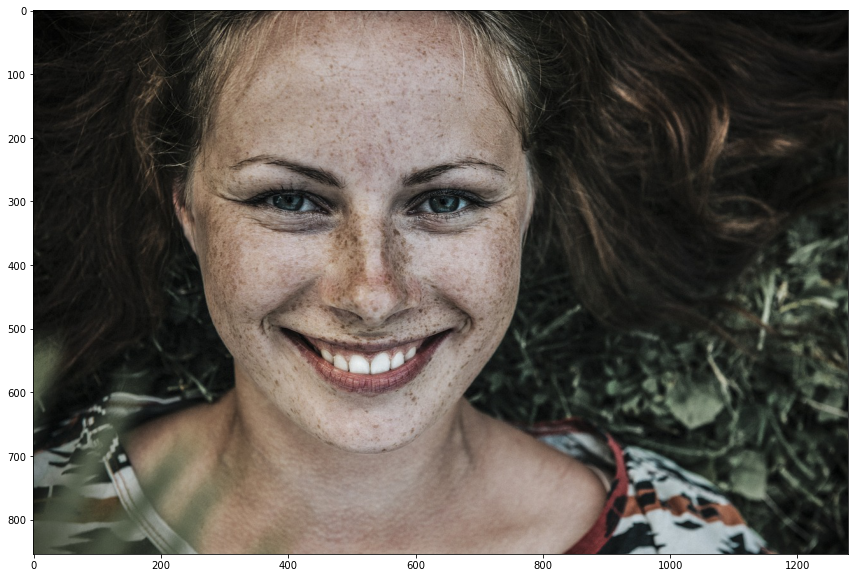

In [20]:
imagem = cv2.imread("imgs/px-woman-smilings.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)

In [21]:
# na pasta tem o de 68 e o de 5 pontos
# são a quantidade de pontos que o classificador marca no rosto
# o de 5 é muito mais rápido, mas da para extrair bem menos informação
classificador_dlib_68_path = "classificadores/shape_predictor_68_face_landmarks.dat"
# modelo já treinado
classificador_dlib = dlib.shape_predictor(classificador_dlib_68_path)
face_detector = dlib.get_frontal_face_detector()

In [22]:
def anotar_rosto(imagem):
    # face_detector retorna um retangulo que delimita o rosto na imagem
    # o parametro 1 é para modificar o tamanho da imagem e procurar outros rostos de diferentes tamanhos
    # como só tem um rosto, não precisamos disso, então se passa apenas 1
    retangulos = face_detector(imagem, 1)
    
    if len(retangulos) == 0:
        return None
    
    # k é o contador, c são as coordenadas são os pontos que delimitam o retangulo
    for k, c in enumerate(retangulos):
        cv2.rectangle(imagem, (c.left(), c.top()), (c.right(), c.bottom()), (255, 255, 0), 2)
        
    return imagem

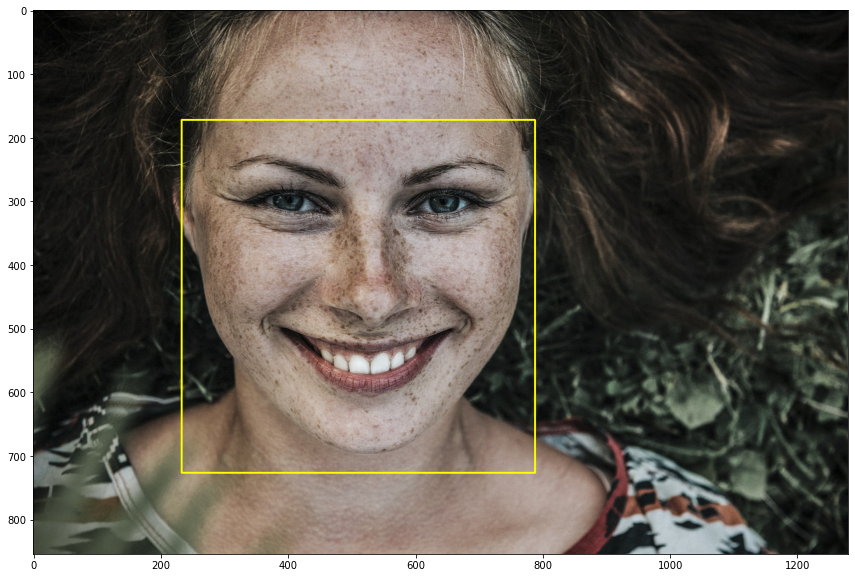

In [23]:
imagem_anotada = imagem.copy()
imagem_anotada = anotar_rosto(imagem_anotada)

plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)

In [24]:
def pontos_marcos_faciais(imagem):
    retangulos = face_detector(imagem);
    
    if len(retangulos) == 0:
        return None
    
    marcos = []
    # para cada retangulo, ou rosto, encontrado na imagem
    for ret in retangulos:
        # adiciona em marcos uma np.matrix formada pelas coordenadas x e y do ponto p
        # para cada ponto p retornado pelo classificador do dlib
        marcos.append(np.matrix([(p.x, p.y) for p in classificador_dlib(imagem, ret).parts()]))
    
    return marcos

In [25]:
# contem uma array com 68 pontos para cada rosto na imagem
marcos_faciais = pontos_marcos_faciais(imagem)
print("Encontrados %d rostos com %d marcos faciais cada" % (len(marcos_faciais), len(marcos_faciais[0])))

Encontrados 1 rostos com 68 marcos faciais cada


In [26]:
def anotar_marcos_faciais(imagem, marcos):
    
    for marco in marcos:
        for i, ponto in enumerate(marco):
            # pintando a bolinha no marco
            centro = (ponto[0,0], ponto[0,1])
            cv2.circle(imagem, centro, 3, (255, 255, 0), -1)
            # legendando a bolinha com o número do ponto
            cv2.putText(imagem, str(i), centro, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
            
    return imagem

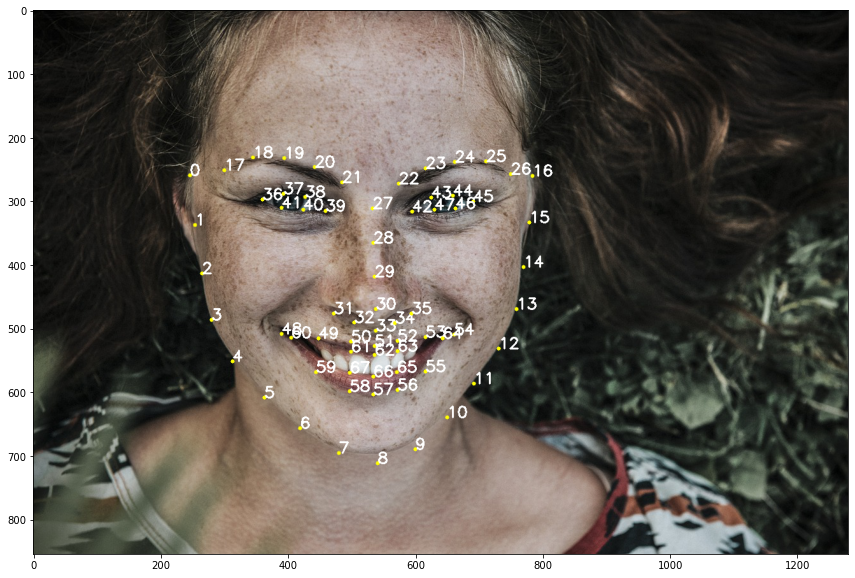

In [27]:
imagem_anotada = imagem.copy()
imagem_anotada = anotar_marcos_faciais(imagem_anotada, marcos_faciais)

plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)

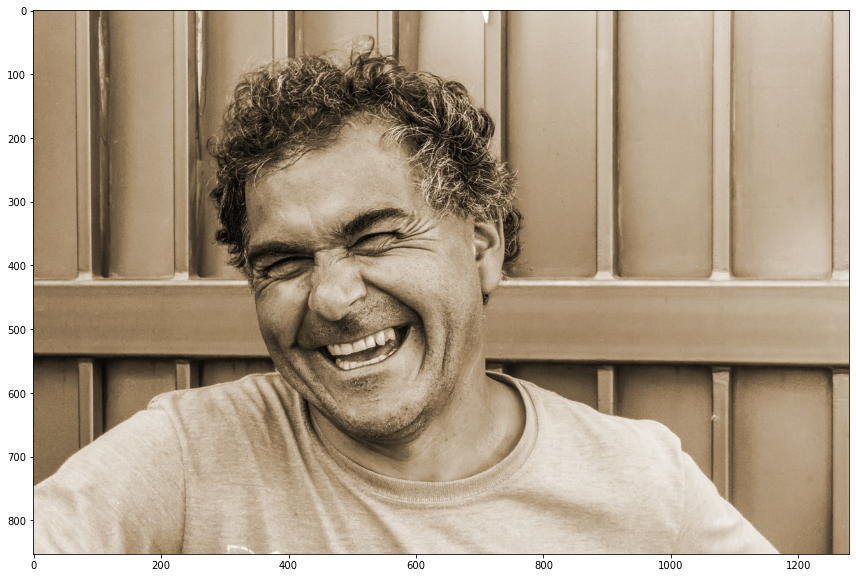

In [28]:
imagem2 = cv2.imread("imgs/px-man-happy.jpg")
imagem2 = cv2.cvtColor(imagem2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem2)

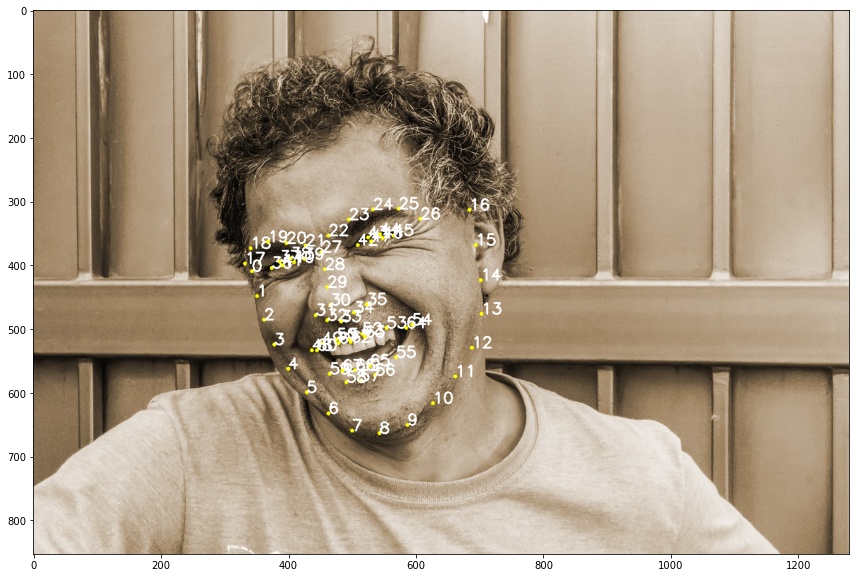

In [34]:
imagem_anotada = imagem2.copy()
marcos = pontos_marcos_faciais(imagem_anotada)
imagem_anotada = anotar_marcos_faciais(imagem_anotada, marcos)

plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)

In [30]:
FACE = list(range(17, 68))
FACE_COMPLETA = list(range(0, 68))
LABIO = list(range(48, 61))
SOMBRANCELHA_DIREITA = list(range(17, 22))
SOMBRANCELHA_ESQUERDA = list(range(22, 27))
OLHO_DIREITO = list(range(36, 42))
OLHO_ESQUERDO = list(range(42, 48))
NARIZ = list(range(27, 35))
MANDIBULA = list(range(0, 17))

In [31]:
# essa é uma forma de calcular a razao de abertura dos olhos
# tirada dum artigo aí
# como um rosto mais próximo ou mais distante da tela faz com que os pontos aparentem estar mais próximos ou distantes
# é importante usar aspectos de razao para fazer os cálculos
# dessa forma o tamanho da imagem ou distância da câmera não interfere
def aspecto_razao_olhos(pontos_olhos):
    a = dist.euclidean(pontos_olhos[1], pontos_olhos[5])
    b = dist.euclidean(pontos_olhos[2], pontos_olhos[4])
    c = dist.euclidean(pontos_olhos[0], pontos_olhos[3])
    
    aspecto_razao = (a + b)/ (2 * c)
    
    return aspecto_razao

In [32]:
# função para ligar os pontos dos olhos
def anotar_marcos_casca_convexa(imagem, marcos):
    retangulos = face_detector(imagem, 1)
    
    if len(retangulos) == 0:
        return None
    
    for i, ret in enumerate(retangulos):
        marco = marcos[i]
        
        pontos = cv2.convexHull(marco[OLHO_ESQUERDO])
        cv2.drawContours(imagem, [pontos], 0, (0, 255, 0), 2)
        
        pontos = cv2.convexHull(marco[OLHO_DIREITO])
        cv2.drawContours(imagem, [pontos], 0, (0, 255, 0), 2)
        
    return imagem

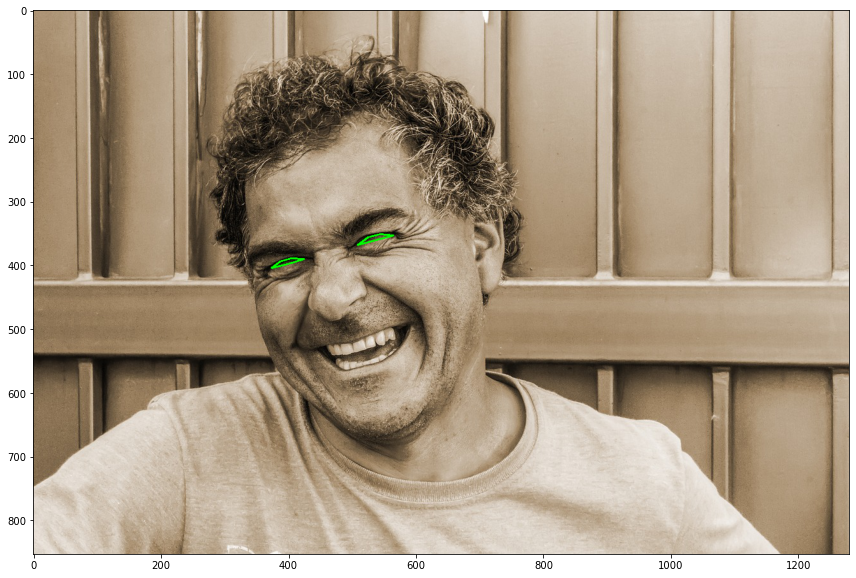

In [36]:
imagem_anotada = imagem2.copy()
marcos = pontos_marcos_faciais(imagem_anotada)
imagem_anotada = anotar_marcos_casca_convexa(imagem_anotada, marcos)

plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)

In [38]:
valor_aspecto_olho_direito = aspecto_razao_olhos(marcos_faciais[0][OLHO_DIREITO])
valor_aspecto_olho_esquerdo = aspecto_razao_olhos(marcos_faciais[0][OLHO_ESQUERDO])

print("olho direito: " + str(valor_aspecto_olho_direito))
print("olho esquerdo: " + str(valor_aspecto_olho_esquerdo))

olho direito: 0.2108232057057904
olho esquerdo: 0.20571944367025768


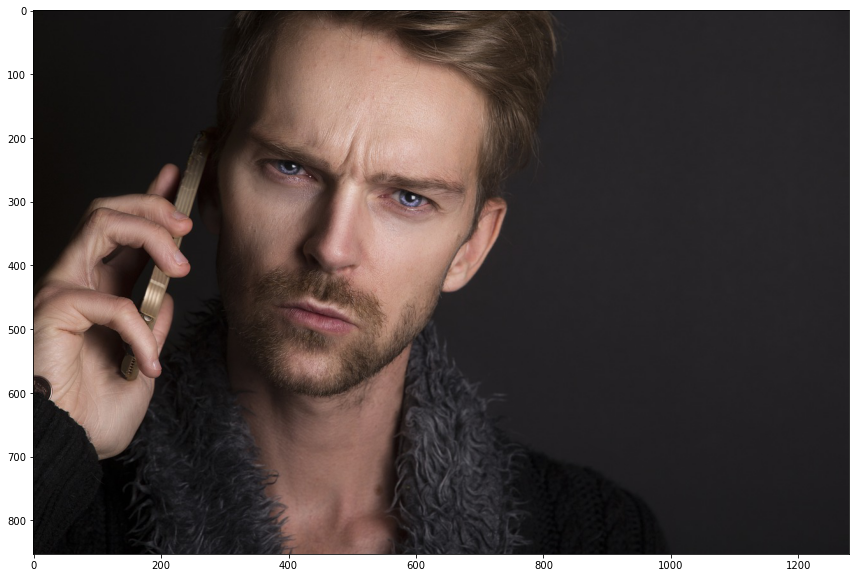

In [40]:
pessoa_seria = cv2.imread("imgs/px-man-serious.jpg")
pessoa_seria = cv2.cvtColor(pessoa_seria, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(pessoa_seria)

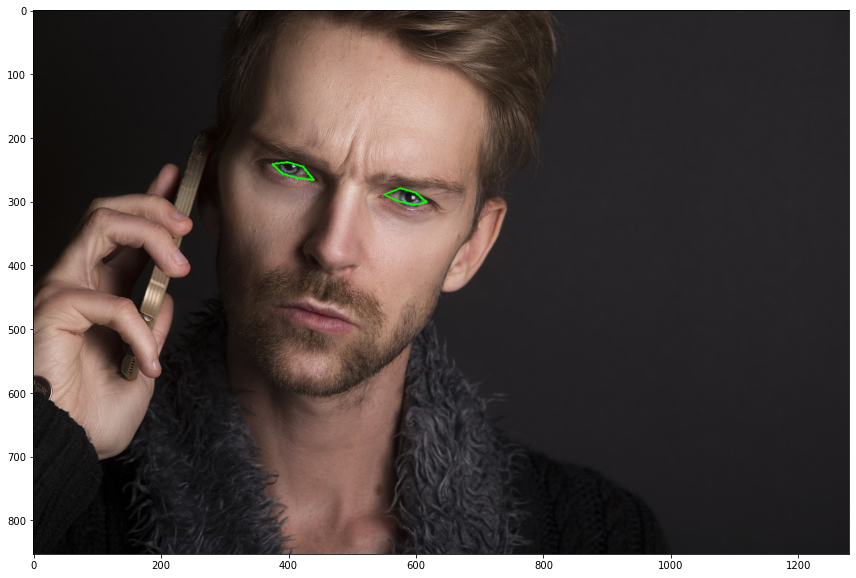

In [41]:
marcos_faciais = pontos_marcos_faciais(pessoa_seria)
imagem_anotada = pessoa_seria.copy()
imagem_anotada = anotar_marcos_casca_convexa(imagem_anotada, marcos_faciais)

plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)

In [42]:
valor_aspecto_olho_direito = aspecto_razao_olhos(marcos_faciais[0][OLHO_DIREITO])
valor_aspecto_olho_esquerdo = aspecto_razao_olhos(marcos_faciais[0][OLHO_ESQUERDO])

print("olho direito: " + str(valor_aspecto_olho_direito))
print("olho esquerdo: " + str(valor_aspecto_olho_esquerdo))

olho direito: 0.28284271247461895
olho esquerdo: 0.2911246297484175
